In [3]:
%load_ext autoreload
%autoreload 2
import sys
from multiprocessing import Pool
sys.path.append('../')
import matching_catalog
import matplotlib.pyplot as plt
from astropy.table import Table
import numpy as np
from regions import Regions
from regions import CircleSkyRegion, CirclePixelRegion

from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy import wcs

mywcs=wcs.WCS(naxis=2) #bidon
mywcs.wcs.ctype = ["RA", "DEC"]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
data_path = '/global/cfs/cdirs/desi/users/cpayerne/data_WP221_Target_selection/photometric_tracer_catalogs/'
catalog = Table.read(data_path + 'cosmos_lbg_udropout_rmax25_5.fits')
data_photom_path = '/global/cfs/cdirs/desi/users/cpayerne/data_WP221_Target_selection/photometric_catalogs/'
regions =  Regions.read(data_photom_path + 'bright_stars_cosmos.reg')

In [5]:
%time regions[0].to_pixel(mywcs)

CPU times: user 5.18 ms, sys: 0 ns, total: 5.18 ms
Wall time: 5.06 ms


<CirclePixelRegion(center=PixCoord(x=151.9077427444798, y=0.6043247679013193), radius=0.003823000000003662)>

In [6]:
catalog_lbg = catalog

In [7]:
def selection_footprint(ra, dec):

    big_rectangle = (dec<3.5) & (dec>0.95) & (ra>149) & (ra<151.2)
    small_rectagle_left = (dec<2.45) & (dec>1.95) & (ra>148.7) & (ra<149.5)
    small_rectangle_right = (dec<2.45) & (dec>1.95) & (ra>150.7) & (ra<151.3)
    small_rectangle_top = (dec<3.50) & (dec>3.25) & (ra>150) & (ra<150.2)
    small_rectangle_bottom = (dec<1.2) & (dec>0.95) & (ra>150) & (ra<150.2)

    sel = big_rectangle 
    sel &= np.invert(small_rectagle_left)  & np.invert(small_rectangle_right)
    sel &= np.invert(small_rectangle_top) & np.invert(small_rectangle_bottom)
    return sel

In [8]:
def selection_masks(ra, dec):
    skycoord = SkyCoord(ra, dec, unit='deg')
    in_mask=np.zeros(ra.size,dtype=bool)
    for i, reg in enumerate(regions):
        if i%1000==0: print(f'{i/len(regions):.1f}')
        in_mask += reg.contains(skycoord, mywcs)
    return in_mask

In [9]:
def compute_random(nb_random,  ra_0, dec_0) :

    radius = 1.61
    ra_inf = ra_0 - radius/np.cos(np.deg2rad(dec_0))
    ra_sup = ra_0 + radius/np.cos(np.deg2rad(dec_0))
    dec_inf =  dec_0 - radius
    dec_sup =  dec_0 + radius
    cos_theta_sup=np.cos(np.deg2rad(dec_inf+90.0))
    cos_theta_inf=np.cos(np.deg2rad(dec_sup+90.0))
    ra = np.random.rand(nb_random*2)*(ra_sup-ra_inf)+ra_inf
    cos_theta = np.random.rand(nb_random*2)*(cos_theta_sup-cos_theta_inf)+cos_theta_inf
    dec = np.rad2deg(np.arccos(cos_theta))-90.0
    sel = selection_footprint(ra, dec)

    return  ra[sel], dec[sel]

In [ ]:
ra, dec = compute_random(80000,  150.120, 2.200)
sel_masks_random = selection_masks(ra, dec)

In [10]:
sel_masks_lbg  = selection_masks(catalog_lbg['RA'], catalog_lbg['DEC'])

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.3
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


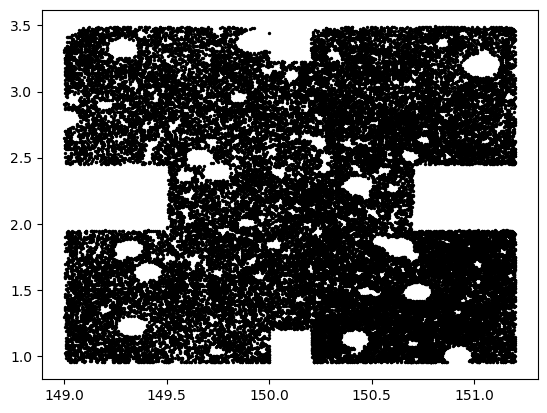

In [11]:
#plt.scatter(catalog_lbg['RA'], catalog_lbg['DEC'], s=0.1)
#plt.scatter(ra[np.invert(sel_masks_random)], dec[np.invert(sel_masks_random)], s=4, c='r')
mask_lbg_footprint = selection_footprint(catalog_lbg['RA'], catalog_lbg['DEC'])
mask_more = catalog_lbg['ST_TRAIL']==0
mask_more *= catalog_lbg['OBJ_TYPE']!=2
mask_more *= catalog_lbg['OBJ_TYPE']!=1
mask_more *= catalog_lbg['FLAG_FIELD_BINARY'][:,1]==True
mask_more *= catalog_lbg['MASK']==0
plt.scatter(catalog_lbg['RA'][mask_lbg_footprint * np.invert(sel_masks_lbg) * mask_more], 
            catalog_lbg['DEC'][mask_lbg_footprint * np.invert(sel_masks_lbg) * mask_more], s=2, c='k')

In [12]:
catalog_lbg_clustering = catalog_lbg[mask_lbg_footprint * np.invert(sel_masks_lbg) * mask_more]

In [13]:
catalog_lbg_clustering.write(data_path + 'masked_cosmos_lbg_udropout_rmax25_5.fits', overwrite=True)

In [ ]:
#catalog_lbg_clustering.write(data_path + 'masked_cosmos_lbg_udropout_rmax25_5.fits')
random_cat = Table()
random_cat['RA'] = ra[np.invert(sel_masks_random)]
random_cat['DEC'] = dec[np.invert(sel_masks_random)]

In [ ]:
random_cat.write(data_path + 'masked_randoms.fits', overwrite=True)